## 方針
- 対数変換
- BoW

In [1]:
import pandas as pd
import numpy as np
import json
# データ可視化ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import re
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb
print('lightgbm version:', lgb.__version__)

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import sklearn
print('sklearn version:', sklearn.__version__)



Bad key "text.kerning_factor" on line 4 in
/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


lightgbm version: 2.3.0
sklearn version: 0.22.1


/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('../data/raw/train_data.csv')
test = pd.read_csv('../data/raw/test_data.csv')

In [3]:
# ↑のjsonファイルをnames.jsonで保存してある前提
with open("columns.json", "r", encoding="utf-8") as f:
     d = json.load(f)
        
train = train.rename(columns=d)
test = test.rename(columns=d)        

In [4]:
pub = pd.read_csv('../data/raw/published_land_price.csv')

In [5]:
pair = {"所在地コード":"市区町村コード","建蔽率":"建ぺい率（％）","容積率":"容積率（％）","駅名":"最寄駅：名称", 
        "地積":"面積（㎡）","市区町村名":"市区町村名",'前面道路の幅員':'前面道路：幅員（ｍ）', 
        "前面道路の方位区分":"前面道路：方位","前面道路区分":"前面道路：種類","形状区分":"土地の形状",
        "用途区分":"都市計画"
         }
pub = pub.rename(columns=pair)
pub = pub.rename(columns=d)

## 不要なカラムを落とす 

In [6]:
delete_columns = ['id', 'Prefecture', 'Municipality', 'DistrictName']
train = train.drop(delete_columns, axis=1)
test = test.drop(delete_columns, axis=1)

In [7]:
train = train.drop_duplicates()

### yが20000の列を削除

In [8]:
train = train.drop(train.query('y >= 16000').index, axis=0)

In [9]:
y = train['y']
train = train.drop('y', axis=1)

In [10]:
data = pd.concat([train, test])

## stationの整形

In [13]:
Near = data['NearestStation'].str.split('(', expand=True)
data = data.drop('NearestStation', axis=1)
data['NearestStation'] = Near[0]

In [14]:
def get_mean(search, cat):
        leng = search.shape[0]
        sum = 0
        for i in range(leng):
            if search.iloc[i][cat] != 0:
                sum += search.iloc[i][cat]
        return sum/leng

In [15]:
new_columns = ['latitude', 'longitude','h31_price', 'h30_price', 'h29_price', 'h28_price', 'h27_price']

data['NearestStation+MunicipalityCode'] = data['NearestStation'] + '+' + data['MunicipalityCode'].astype(str)

for i in new_columns:
    data[i] =data['NearestStation+MunicipalityCode']

def get_mean(search, cat):
        leng = search.shape[0]
        sum = 0
        for i in range(leng):
            if search.iloc[i][cat] != 0:
                sum += search.iloc[i][cat]
        return sum/leng

for i in tqdm(data['NearestStation+MunicipalityCode'].unique()):
    try:
            ns, mc = i.split('+')
            search = pub[pub['MunicipalityCode'] == int(mc)][pub['NearestStation'] == ns]
            try:
                data['latitude'] = data['latitude'].replace(i, get_mean(search, '緯度'))
                data['longitude'] = data['longitude'].replace(i, get_mean(search, '経度'))
                data['h31_price'] = data['h31_price'].replace(i, get_mean(search, 'Ｈ３１価格'))
                data['h30_price'] = data['h30_price'].replace(i, get_mean(search, 'Ｈ３０価格'))
                data['h29_price'] = data['h29_price'].replace(i, get_mean(search, 'Ｈ２９価格'))
                data['h28_price'] = data['h28_price'].replace(i, get_mean(search, 'Ｈ２８価格'))
                data['h27_price'] = data['h27_price'].replace(i, get_mean(search, 'Ｈ２７価格'))
            except:
                try:
                    search = pub[pub['NearestStation'] == ns]
                    data['latitude'] = data['latitude'].replace(i, get_mean(search, '緯度'))
                    data['longitude'] = data['longitude'].replace(i, get_mean(search, '経度'))
                    data['h31_price'] = data['h31_price'].replace(i, get_mean(search, 'Ｈ３１価格'))
                    data['h30_price'] = data['h30_price'].replace(i, get_mean(search, 'Ｈ３０価格'))
                    data['h29_price'] = data['h29_price'].replace(i, get_mean(search, 'Ｈ２９価格'))
                    data['h28_price'] = data['h28_price'].replace(i, get_mean(search, 'Ｈ２８価格'))
                    data['h27_price'] = data['h27_price'].replace(i, get_mean(search, 'Ｈ２７価格'))                                    
                except:
                    data['latitude'] = data['latitude'].replace(i, np.nan)
                    data['longitude'] = data['longitude'].replace(i, np.nan)
                    data['h31_price'] = data['h31_price'].replace(i, np.nan) 
                    data['h30_price'] = data['h30_price'].replace(i, np.nan)
                    data['h29_price'] = data['h29_price'].replace(i, np.nan)
                    data['h28_price'] = data['h28_price'].replace(i, np.nan)
                    data['h27_price'] = data['h27_price'].replace(i, np.nan)                                 
    except:
            continue

/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [16]:
data = data.drop('NearestStation+MunicipalityCode', axis=1)

In [17]:
data['h31_price'] = data['h31_price'].replace(0, np.nan) 
data['h30_price'] = data['h30_price'].replace(0, np.nan)
data['h29_price'] = data['h29_price'].replace(0, np.nan)
data['h28_price'] = data['h28_price'].replace(0, np.nan)
data['h27_price'] = data['h27_price'].replace(0, np.nan) 

In [18]:
price_df = pd.DataFrame({'h31_price': data['h31_price'].values, 'h30_price': data['h30_price'].values, 
                         'h29_price': data['h29_price'].values, 'h28_price': data['h28_price'].values, 
                              'h27_price' : data['h27_price'].values})

In [19]:
price_df['h31_27_mean'] = price_df.mean(axis='columns')
price_df['31-28'] = price_df['h31_price'] - price_df['h28_price']
data = data.drop(['h30_price', 'h29_price', 'h28_price', 'h27_price'], axis=1)
data['h31_27_mean'] = price_df['h31_27_mean']
data['31-28'] = price_df['31-28']

## building_id

In [20]:
data['building_id'] = data.groupby(['MunicipalityCode', 'TimeToNearestStation','BuildingYear', 'Structure', 'Use', 'NearestStation', 'FloorPlan']
                              ).grouper.group_info[0]


## 数値データの整形

In [21]:
def calc_mean_median(df, df_type):
    dumy = df
    dumy = dumy.dropna()
    dumy = dumy.astype(df_type)
    df = df.fillna(dumy.mean())
    df = df.astype(df_type)
    return df

### 最寄駅：距離（分） 

In [22]:
data['TimeToNearestStation'] = data['TimeToNearestStation'].replace('2H?', '120').replace('30分?60分', '45'). \
        replace('1H30?2H', '105').replace('1H?1H30', '75')

In [23]:
data['TimeToNearestStation'] = calc_mean_median(data['TimeToNearestStation'], np.int64)

### 面積

In [24]:
dumy_area = data['Area'].replace('2000㎡以上', np.nan).replace('5000㎡以上', np.nan)
dumy_area = dumy_area.dropna()
dumy_area = dumy_area.astype(np.int64)
# 2000以上5000以下の平均値を取得
area_mean_2000_5000 = np.median([i for i in dumy_area if i > 2000 and i < 5000])
# 5000以上はないので5500で置換
# 欠損値を埋めるための平均と中央値
dim_mean = dumy_area.mean()
dim_median = dumy_area.median()

In [25]:
data['Area'] = data['Area'].replace('2000㎡以上',  area_mean_2000_5000).replace('5000㎡以上', np.nan)
data['Area'] =  data['Area'].fillna(dim_mean)  
data['Area'] = data['Area'].astype(np.int64)

### 間口

In [26]:
data['Frontage'] = data['Frontage'].replace('50.0m以上', '60.0')

In [27]:
data['Frontage'] =   calc_mean_median(data['Frontage'], np.float32)

### 延床面積（㎡）

In [28]:
data['TotalFloorArea'] = data['TotalFloorArea'].replace('2000㎡以上', '2500').replace( '10m^2未満', '5')

In [29]:
data['TotalFloorArea'] =  calc_mean_median(data['TotalFloorArea'], np.int64)

### 築年数

In [30]:
tiku_columns = ['昭和59年', '平成15年', '平成24年', '昭和61年', '平成11年', '昭和60年', '平成19年',
       '平成10年', '昭和57年', '昭和45年', '昭和47年', '昭和43年', '昭和64年', '平成25年',
       '平成16年', '平成9年', '平成5年', '昭和51年', '平成13年', '昭和52年', '昭和55年',
       '昭和54年', '平成2年', '平成21年', '平成22年', '平成18年', '平成14年', '平成6年',
       '平成17年', '昭和62年', '平成12年', '昭和38年', '昭和41年', '昭和48年', '平成20年',
       '昭和53年', '昭和49年', '平成26年', '昭和58年', '昭和56年', '昭和35年', '昭和50年',
       '昭和37年', '平成23年', '平成7年', '平成3年', '昭和63年', '戦前', '平成29年', '昭和36年',
       '平成28年', '昭和39年', '平成4年', '平成27年', '昭和42年', '昭和31年', '平成30年',
       '昭和44年', '昭和29年', '平成8年', '昭和27年', '昭和46年', '昭和30年', '昭和33年',
       '昭和32年', '昭和40年', '昭和26年', '昭和34年', '昭和25年', '昭和28年', '昭和22年',
       '昭和24年', '昭和23年', '昭和21年', '平成31年']

for i in tiku_columns:
    if '平成' in i:
        year = int(i.replace('年', '').replace('平成', '')) +2000-12
        data['BuildingYear'] = data['BuildingYear'].replace(i, year)
    if '昭和' in i:
        year = int(i.replace('年', '').replace('昭和', '')) + 1925
        data['BuildingYear'] = data['BuildingYear'].replace(i, year)
        

In [31]:
data['BuildingYear'].unique()

array([1984, 2003, 2012, 1986, 1999, 1985, 2007, 1998, nan, 1982, 1970,
       1972, 1968, 1989, 2013, 2004, 1997, 1993, 1976, 2001, 1977, 1980,
       1979, 1990, 2009, 2010, 2006, 2002, 1994, 2005, 1987, 2000, 1963,
       1966, 1973, 2008, 1978, 1974, 2014, 1983, 1981, 1960, 1975, 1962,
       2011, 1995, 1991, 1988, '戦前', 2017, 1961, 2016, 1964, 1992, 2015,
       1967, 1956, 2018, 1969, 1954, 1996, 1952, 1971, 1955, 1958, 1957,
       1965, 1951, 1959, 1950, 1953, 1947, 1949, 1948, 1946, 2019],
      dtype=object)

In [32]:
data['BuildingYear'] = data['BuildingYear'].replace('戦前', 1960)

In [33]:
data['BuildingYear'] =  calc_mean_median(data['BuildingYear'], np.int64)

In [34]:
data['BuildingYear'] = data['BuildingYear'] -1900

## 前面道路：幅員（ｍ）

In [35]:
data['Breadth']=  calc_mean_median(data['Breadth'], np.float64)

###  建ぺい率（％) 容積率（％） 

In [36]:
data['CoverageRatio']=  calc_mean_median(data['CoverageRatio'], np.float64)
data['FloorAreaRatio']=  calc_mean_median(data['FloorAreaRatio'], np.float64)

### 取引時点

In [37]:
torihiki_columns = data['Period'].unique()

In [38]:
for i, value in enumerate(sorted(torihiki_columns)):
    data['Period'] =  data['Period'].replace(value, i)

## カテゴリーデータの整形

In [40]:
data.Remarks.unique()

array([nan, '私道を含む取引', '隣地の購入', '関係者間取引', '調停・競売等', '隣地の購入、私道を含む取引',
       '隣地の購入、関係者間取引、私道を含む取引', '関係者間取引、私道を含む取引', 'その他事情有り',
       '調停・競売等、私道を含む取引', '瑕疵有りの可能性', '古屋付き・取壊し前提', '隣地の購入、関係者間取引',
       '私道を含む取引、その他事情有り', '他の権利・負担付き', '隣地の購入、その他事情有り',
       '瑕疵有りの可能性、私道を含む取引', '隣地の購入、調停・競売等、私道を含む取引', '古屋付き・取壊し前提、私道を含む取引',
       '他の権利・負担付き、私道を含む取引', '関係者間取引、調停・競売等、私道を含む取引', '他の権利・負担付き、調停・競売等',
       '調停・競売等、その他事情有り', '古屋付き・取壊し前提、瑕疵有りの可能性', '隣地の購入、瑕疵有りの可能性',
       '隣地の購入、調停・競売等'], dtype=object)

In [39]:
data

,Type,Region,MunicipalityCode,TimeToNearestStation,FloorPlan,Area,LandShape,Frontage,TotalFloorArea,BuildingYear,...,Period,Renovation,Remarks,NearestStation,latitude,longitude,h31_price,h31_27_mean,31-28,building_id
0,中古マンション等,NaN,13101,1,２ＬＤＫ,55,NaN,9.699066,177,84,...,49,改装済,NaN,飯田橋,128519.591,503087.409,2740000.0,2443000.0,450000.0,-1
1,中古マンション等,NaN,13101,5,１Ｋ,20,NaN,9.699066,177,103,...,49,未改装,NaN,飯田橋,128519.591,503087.409,2740000.0,2443000.0,450000.0,-1
2,中古マンション等,NaN,13101,3,１ＬＤＫ,45,NaN,9.699066,177,112,...,48,未改装,NaN,飯田橋,128519.591,503087.409,2740000.0,2443000.0,450000.0,472
3,中古マンション等,NaN,13101,5,１Ｒ,20,NaN,9.699066,177,103,...,48,未改装,NaN,飯田橋,128519.591,503087.409,2740000.0,2443000.0,450000.0,819
4,宅地(土地と建物),商業地,13101,3,NaN,80,ほぼ台形,6.800000,330,86,...,47,NaN,NaN,飯田橋,128519.591,503087.409,2740000.0,2443000.0,450000.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34839,宅地(土地と建物),住宅地,13401,10,NaN,840,ほぼ台形,27.000000,60,97,...,51,NaN,NaN,NaN,NaN,NaN,NaN,808100.0,705500.0,-1
34840,宅地(土地),住宅地,13401,10,NaN,370,ほぼ長方形,14.000000,177,97,...,51,NaN,NaN,NaN,NaN,NaN,NaN,808100.0,705500.0,-1
34841,宅地(土地),住宅地,13401,10,NaN,520,不整形,23.900000,177,97,...,50,NaN,NaN,NaN,NaN,NaN,NaN,808100.0,705500.0,-1
34842,宅地(土地),住宅地,13421,10,NaN,380,ほぼ台形,9.699066,177,97,...,50,NaN,NaN,NaN,NaN,NaN,NaN,808100.0,705500.0,-1


### 最寄駅：名称 - labelエンコード

In [37]:
# data['L'] = data['FloorPlan'].map(lambda x: 1 if 'Ｌ' in str(x) else 0)
# data['D'] = data['FloorPlan'].map(lambda x: 1 if 'Ｄ' in str(x) else 0)
# data['K'] = data['FloorPlan'].map(lambda x: 1 if 'Ｋ' in str(x) else 0)
# data['S'] = data['FloorPlan'].map(lambda x: 1 if 'Ｓ' in str(x) else 0)
# data['R'] = data['FloorPlan'].map(lambda x: 1 if 'Ｒ' in str(x) else 0)
# data['Maisonette'] = data['FloorPlan'].map(lambda x: 1 if 'メゾネット' in str(x) else 0)
# data['OpenFloor'] = data['FloorPlan'].map(lambda x: 1 if 'オープンフロア' in str(x) else 0)
# data['Studio'] = data['FloorPlan'].map(lambda x: 1 if 'スタジオ' in str(x) else 0)

### 用途

In [38]:
use_dummy =data['Use'].fillna('missing')
use_dummy=  use_dummy.str.replace('共同住宅', '共同')
for i in use_dummy.unique():
    new_use = ''
    if '住宅' in i:
        new_use += '1'
    else:
        new_use += '0'
    new_use += ','
    if '事務所' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '店舗' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if 'その他' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '倉庫' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '駐車場' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '工場' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '共同' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '作業場' in i:
        new_use += '1'
    else:
        new_use += '0'        
    use_dummy = use_dummy.replace(i, new_use)

In [39]:
data_use = use_dummy.str.split(',', expand=True)

In [40]:
use_columns={0: 'Housing', 1: 'office', 2: 'store', 3: 'other_use', 4: 'Warehouse', 5: 'parking', 6: 'plant', 7: 'shareHouse', 8: 'Workshop'}
data_use = data_use.rename(columns=use_columns)

In [41]:
for i in data_use.columns:
    data_use[i] = data_use[i].astype(np.int64)

In [42]:
for i in data_use.columns:
    data[i] = data_use[i]

## ラベルエンコーディング

In [43]:
categorical_features = ['Type', 'Region', 'NearestStation', 'FloorPlan','LandShape', 'Structure', 'Use', 'Purpose', 'Direction', \
         'Classification', 'CityPlanning', 'Renovation', 'Remarks']

In [44]:
for c in categorical_features:
    data[c] =  data[c].fillna('missing') 

In [45]:
from sklearn.preprocessing import LabelEncoder

for c in categorical_features:
    le = LabelEncoder()
    le.fit(data[c])
    data[c] = le.transform(data[c])

## 値の微調整

In [46]:
data['longitude'] = data['longitude'] - 500000

In [47]:
data['latitude'] = data['latitude'] -120000

In [48]:
price_cols = ['h31_price', 'h31_27_mean']   
for i in price_cols:
    data[i] = data[i] /10000

## 市域コード別に平均と最大を計算


In [49]:
city_mean_colums = ['MunicipalityCode', 'Area', 'LandShape', 'Frontage', 'BuildingYear',
                           'TotalFloorArea', 'h31_price', 'Breadth', 'Structure', 'FloorAreaRatio']

data_city_mean =  data[city_mean_colums].groupby('MunicipalityCode').mean()

for i in city_mean_colums:
    if i != 'MunicipalityCode':
        data['citycode_mean_' + i] = data['MunicipalityCode']
        for j, value in enumerate(data['MunicipalityCode'].unique()):
            data['citycode_mean_' + i] = data['citycode_mean_' + i].replace(value, data_city_mean[i].iloc[j])

In [50]:
data_city_max =  data[city_mean_colums].groupby('MunicipalityCode').max()

for i in city_mean_colums:
    if i != 'MunicipalityCode':
        data['citycode_max_' + i] = data['MunicipalityCode']
        for j, value in enumerate(data['MunicipalityCode'].unique()):
            data['citycode_max_' + i] = data['citycode_max_' + i].replace(value, data_city_mean[i].iloc[j])

In [51]:
period_mean_colums = ['Period', 'Area', 'LandShape', 'Frontage', 'BuildingYear',
                           'TotalFloorArea', 'h31_price', 'Breadth', 'Structure', 'FloorAreaRatio', 'longitude']

data_period_mean =  data[period_mean_colums].groupby('Period').mean()

for i in period_mean_colums:
    if i != 'Period':
        data['period_mean_' + i] = data['Period']
        for j, value in enumerate(data['Period'].unique()):
            data['period_mean_' + i] = data['period_mean_' + i].replace(value, data_period_mean[i].iloc[j])
            
data_period_max =  data[period_mean_colums].groupby('Period').max()

for i in period_mean_colums:
    if i != 'Period':
        data['period_max_' + i] = data['Period']
        for j, value in enumerate(data['Period'].unique()):
            data['period_max_' + i] = data['period_max_' + i].replace(value, data_period_max[i].iloc[j])        

In [52]:
data['TimeToNearestStation_NearestStation'] = data['NearestStation'] * data['TimeToNearestStation']
data['h31_27_mean_office'] = data['office'] * data['h31_27_mean']
data['h31_27_mean_ostore'] = data['store'] * data['h31_27_mean']
data['office_and_store'] = data['office'] * data['store']

In [53]:
drop_columns = ['citycode_max_Structure', 'building_id', 'FloorPlan', 'plant',
       'period_max_Structure', 'period_max_LandShape',
       'period_max_Frontage', 'period_max_TotalFloorArea',
       'period_max_longitude']

data = data.drop(drop_columns, axis=1)

In [54]:
train = data[:len(train)]
test = data[len(train):]

## 学習

In [55]:
scores = []
y_pred = np.zeros(test.shape[0])
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train):
    tr_x, va_x = train.iloc[tr_idx], train.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

    train_data = lgb.Dataset(tr_x, tr_y)
    valid_data = lgb.Dataset(va_x, va_y)
    params = {
        'objective': 'regression',
        'metric': 'mape',
        'learning_rate': 0.001,
        'max_depth': -1,
        'num_leaves': 255,
        'max_bin': 255,
        'colsample_bytree': 0.8,
        'subsample': 0.8,
        'nthread': -1,
        'bagging_freq': 1,
        'verbose': -1,
        'seed': 1
#         'seed': random.randint(1, 100),
    }
    model = lgb.train(params, train_data, valid_sets=[train_data, valid_data],
                      num_boost_round=10000, early_stopping_rounds=200,
                      verbose_eval=200)

    y_val_pred = model.predict(va_x)
    val_score = np.sqrt(mean_squared_error(va_y, y_val_pred))
    y_pred  += model.predict(test, num_iteration=model.best_iteration)
    scores.append(val_score)

print('RMSE:', np.mean(scores))

Training until validation scores don't improve for 200 rounds
[200]	training's mape: 1.69454	valid_1's mape: 1.68017
[400]	training's mape: 1.45426	valid_1's mape: 1.44187
[600]	training's mape: 1.25814	valid_1's mape: 1.24797
[800]	training's mape: 1.09729	valid_1's mape: 1.08923
[1000]	training's mape: 0.963779	valid_1's mape: 0.957879
[1200]	training's mape: 0.853867	valid_1's mape: 0.85006
[1400]	training's mape: 0.762473	valid_1's mape: 0.7607
[1600]	training's mape: 0.686885	valid_1's mape: 0.687226
[1800]	training's mape: 0.625577	valid_1's mape: 0.627605
[2000]	training's mape: 0.574874	valid_1's mape: 0.578878
[2200]	training's mape: 0.532492	valid_1's mape: 0.537901
[2400]	training's mape: 0.497099	valid_1's mape: 0.503767
[2600]	training's mape: 0.467712	valid_1's mape: 0.475597
[2800]	training's mape: 0.442991	valid_1's mape: 0.451978
[3000]	training's mape: 0.422259	valid_1's mape: 0.432127
[3200]	training's mape: 0.40469	valid_1's mape: 0.415293
[3400]	training's mape: 0.

[7400]	training's mape: 0.291034	valid_1's mape: 0.31086
[7600]	training's mape: 0.289404	valid_1's mape: 0.309643
[7800]	training's mape: 0.28778	valid_1's mape: 0.308465
[8000]	training's mape: 0.286257	valid_1's mape: 0.30739
[8200]	training's mape: 0.284755	valid_1's mape: 0.306262
[8400]	training's mape: 0.283414	valid_1's mape: 0.305356
[8600]	training's mape: 0.282162	valid_1's mape: 0.304587
[8800]	training's mape: 0.281033	valid_1's mape: 0.303844
[9000]	training's mape: 0.279833	valid_1's mape: 0.303194
[9200]	training's mape: 0.278747	valid_1's mape: 0.302632
[9400]	training's mape: 0.277747	valid_1's mape: 0.301923
[9600]	training's mape: 0.276756	valid_1's mape: 0.301263
[9800]	training's mape: 0.275838	valid_1's mape: 0.300805
[10000]	training's mape: 0.27499	valid_1's mape: 0.300287
Did not meet early stopping. Best iteration is:
[10000]	training's mape: 0.27499	valid_1's mape: 0.300287
Training until validation scores don't improve for 200 rounds
[200]	training's mape: 

In [63]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns
feature_importances['importance'] = model.feature_importance()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
24,h31_price,236713
4,Area,211817
6,Frontage,126863
14,Breadth,124942
7,TotalFloorArea,112007
...,...,...
31,Warehouse,2626
19,Renovation,2536
51,citycode_max_FloorAreaRatio,2350
32,parking,1833


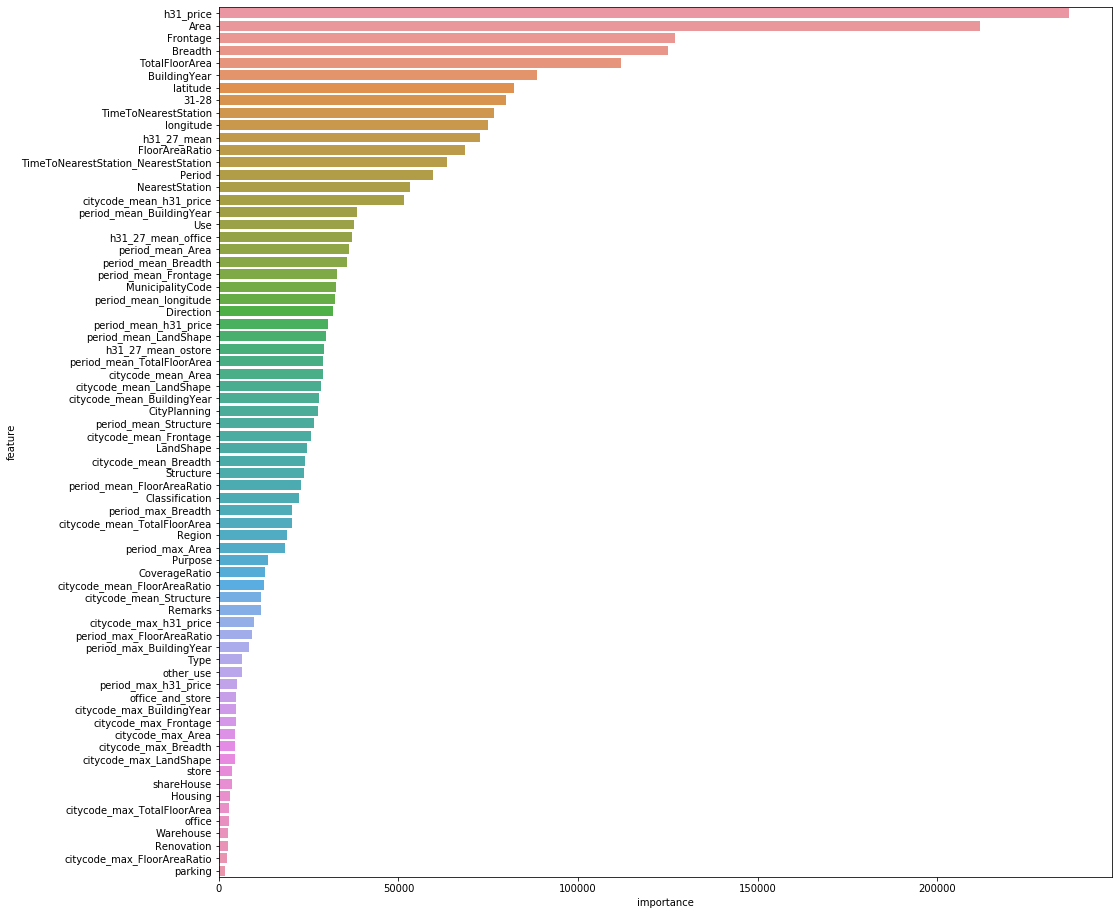

In [64]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.head(70), x='importance', y='feature')

In [65]:
y_pred_fi = y_pred /4
y_pred_fi = np.round(y_pred_fi, 2)

In [66]:
submit = pd.read_csv('../data/raw/test_data.csv')

In [67]:
sub = pd.DataFrame({'id': submit['id'], 'y': y_pred_fi})

In [70]:
sub['y'].describe()

count    34844.000000
mean        64.874247
std        162.855004
min          0.000000
25%         23.150000
50%         36.920000
75%         55.772500
max       7410.420000
Name: y, dtype: float64

In [69]:
for i in sub[sub['y'] < 0]['id']:
    sub['y'][i-1] = 0 

/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
sub.to_csv('sub_lgbm_8.csv', index=False)

## Area400以上 and MunicipalityCodeが13117以下のtrainでモデル作って学習
これに実際に流すのは
### test.query('Area > 700 and MunicipalityCode < 13117')
baseとの出力の違いをみる

In [73]:
train['y'] = y

/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
high_train = train.query('Area >= 400 and MunicipalityCode < 13117')

In [76]:
high_x = high_train.drop('y', axis=1)
high_y = high_train['y']

In [77]:
high_y_pred = np.zeros(test.shape[0])
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(high_x):
    tr_x, va_x = high_x.iloc[tr_idx], high_x.iloc[va_idx]
    tr_y, va_y = high_y.iloc[tr_idx], high_y.iloc[va_idx]

    train_data = lgb.Dataset(tr_x, tr_y)
    valid_data = lgb.Dataset(va_x, va_y)
    params = {
        'objective': 'regression',
        'metric': 'mape',
        'learning_rate': 0.001,
        'max_depth': -1,
        'num_leaves': 255,
        'max_bin': 255,
        'colsample_bytree': 0.8,
        'subsample': 0.8,
        'nthread': -1,
        'bagging_freq': 1,
        'verbose': -1,
        'seed': 1
    }
    high_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data],
                      num_boost_round=10000, early_stopping_rounds=200,
                      verbose_eval=200)

    y_val_pred = high_model.predict(va_x)
    val_score = np.sqrt(mean_squared_error(va_y, y_val_pred))
    y_pred  += high_model.predict(test, num_iteration=high_model.best_iteration)
    scores.append(val_score)

print('RMSE:', np.mean(scores))

Training until validation scores don't improve for 200 rounds
[200]	training's mape: 1.68674	valid_1's mape: 1.69928
[400]	training's mape: 1.44058	valid_1's mape: 1.475
[600]	training's mape: 1.23646	valid_1's mape: 1.29292
[800]	training's mape: 1.06858	valid_1's mape: 1.14525
[1000]	training's mape: 0.928738	valid_1's mape: 1.02321
[1200]	training's mape: 0.812248	valid_1's mape: 0.924573
[1400]	training's mape: 0.714477	valid_1's mape: 0.843495
[1600]	training's mape: 0.632811	valid_1's mape: 0.77768
[1800]	training's mape: 0.564549	valid_1's mape: 0.723644
[2000]	training's mape: 0.507345	valid_1's mape: 0.680126
[2200]	training's mape: 0.459527	valid_1's mape: 0.645151
[2400]	training's mape: 0.419476	valid_1's mape: 0.616966
[2600]	training's mape: 0.385816	valid_1's mape: 0.594366
[2800]	training's mape: 0.357509	valid_1's mape: 0.575721
[3000]	training's mape: 0.333562	valid_1's mape: 0.560765
[3200]	training's mape: 0.313308	valid_1's mape: 0.549575
[3400]	training's mape: 0.

In [211]:
high_y_pred = y_pred /4
high_y_pred = np.round(high_y_pred, 2)

In [212]:
test_n = test

In [213]:
test_n['y_pred'] = y_pred_fi
test_n['y_high'] = high_y_pred

/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [214]:
drop = ['Renovation', 'Remarks', 'NearestStation', 'latitude', 'longitude',
       'h31_price', 'h31_27_mean', '31-28', 'Housing', 'office', 'store',
       'other_use', 'Warehouse', 'parking', 'shareHouse', 'Workshop',
       'citycode_mean_Area', 'citycode_mean_LandShape',
       'citycode_mean_Frontage', 'citycode_mean_BuildingYear',
       'citycode_mean_TotalFloorArea', 'citycode_mean_h31_price',
       'citycode_mean_Breadth', 'citycode_mean_Structure',
       'citycode_mean_FloorAreaRatio', 'citycode_max_Area',
       'citycode_max_LandShape', 'citycode_max_Frontage',
       'citycode_max_BuildingYear', 'citycode_max_TotalFloorArea',
       'citycode_max_h31_price', 'citycode_max_Breadth',
       'citycode_max_FloorAreaRatio', 'period_mean_Area',
       'period_mean_LandShape', 'period_mean_Frontage',
       'period_mean_BuildingYear', 'period_mean_TotalFloorArea',
       'period_mean_h31_price', 'period_mean_Breadth', 'period_mean_Structure',
       'period_mean_FloorAreaRatio', 'period_mean_longitude',
       'period_max_Area', 'period_max_BuildingYear', 'period_max_h31_price',
       'period_max_Breadth', 'period_max_FloorAreaRatio',
       'TimeToNearestStation_NearestStation', 'h31_27_mean_office',
       'h31_27_mean_ostore', 'office_and_store']
test_n = test_n.drop(drop, axis=1)

In [215]:
drop = ['TimeToNearestStation',  'LandShape', 'BuildingYear', 'Structure',
       'Use', 'Purpose', 'Direction']
test_n = test_n.drop(drop, axis=1)

In [216]:
test_n.query('Area > 700 and MunicipalityCode < 13117')

,Type,Region,MunicipalityCode,Area,Frontage,TotalFloorArea,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,y_pred,y_high
27,2,2,13101,770,28.000000,2500,2,11.0,1,80.0,600.0,50,3397.08,6415.04
217,2,2,13101,780,14.400000,1300,2,20.0,11,60.0,400.0,54,2606.46,5899.36
303,2,2,13101,780,40.000000,2500,2,15.0,1,80.0,600.0,54,4673.61,9581.62
1305,2,2,13103,3100,60.000000,2500,14,13.5,1,80.0,500.0,50,6268.21,12225.97
1739,2,1,13103,1000,28.000000,2500,2,5.1,11,60.0,300.0,51,2773.02,5573.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16268,1,1,13115,1700,40.000000,177,2,5.0,10,50.0,100.0,53,802.75,1693.83
16296,1,1,13115,1600,46.900002,177,2,6.0,12,60.0,200.0,50,859.96,1872.68
16447,2,1,13115,1600,15.000000,1600,2,7.3,10,50.0,100.0,54,853.13,2074.27
16505,1,1,13115,870,27.000000,177,2,6.4,13,60.0,150.0,53,479.14,1005.34


In [217]:
# for i in test_n.query('Area > 700 and MunicipalityCode < 13117').index:
#     test_n['y_pred'][i] = test_n['y_pred'][i]*0.8 +  test_n['y_high'][i]*0.2

In [218]:
## 3の実装
for i in test_n.query('Area > 400 and MunicipalityCode < 13117').index:
    test_n['y_pred'][i] = test_n['y_pred'][i]*0.9 +  test_n['y_high'][i]*0.1
    
for i in test_n.query('Area == 3100 and MunicipalityCode < 13117').index:
    test_n['y_pred'][i] = test_n['y_pred'][i]*0.2 +  test_n['y_high'][i]*0.8

/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [219]:
y_pred_2 = np.round(test_n['y_pred'], 2)
sub_2 = pd.DataFrame({'id': submit['id'], 'y': y_pred_2})

In [220]:
sub_2['y'].describe()

count    34844.000000
mean        66.281721
std        196.331423
min        -12.050000
25%         23.150000
50%         36.920000
75%         55.772500
max      13516.190000
Name: y, dtype: float64

In [221]:
for i in sub_2[sub_2['y'] < 0]['id']:
    sub_2['y'][i-1] = 0 

sub_2.to_csv('sub_lgbm_8_3.csv', index=False)

/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 次なる思考

In [137]:
train_50_45 = train.query('Period < 50 and Period > 44')
train_44_40 = train.query('Period < 45 and Period > 39')

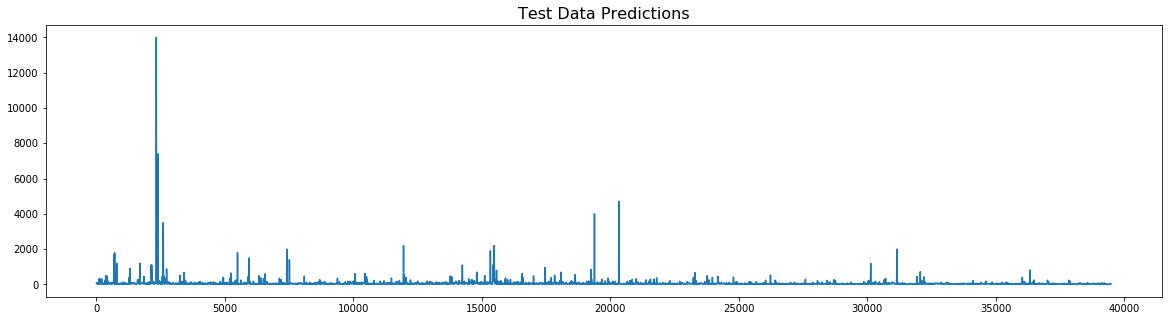

In [138]:
plt.figure(figsize=(20,5))
res = 10
plt.plot(range(0,train_50_45.shape[0],res), train_50_45.y[0::res])
# 並べて表示も可能
# plt.plot(range(0,sub4.shape[0],res), y_pred_2[0::res])

plt.title('Test Data Predictions',size=16)
plt.show()

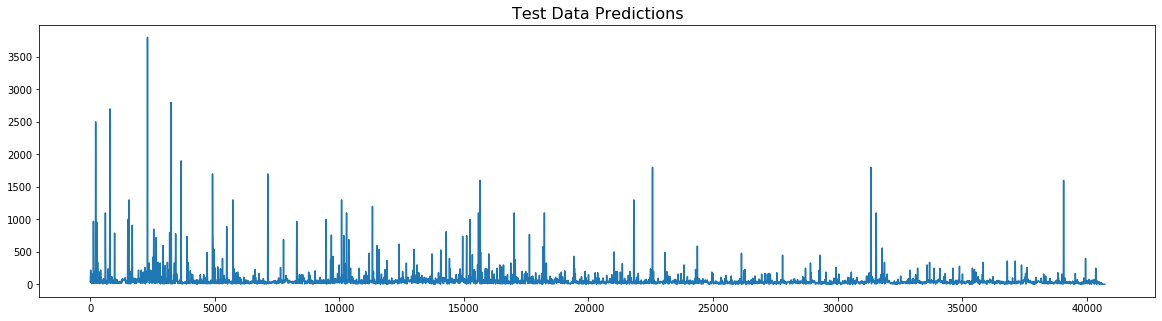

In [139]:
plt.figure(figsize=(20,5))
res = 10
plt.plot(range(0,train_44_40.shape[0],res), train_44_40.y[0::res])
# 並べて表示も可能
# plt.plot(range(0,sub4.shape[0],res), y_pred_2[0::res])

plt.title('Test Data Predictions',size=16)
plt.show()

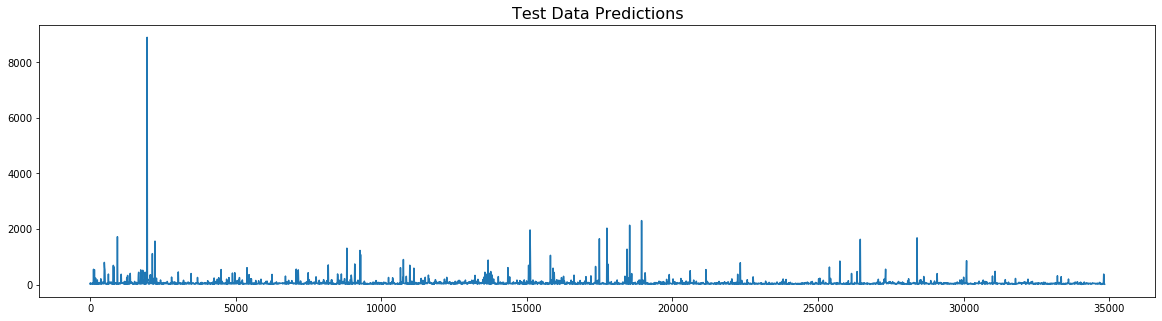

In [140]:
plt.figure(figsize=(20,5))
res = 10
plt.plot(range(0,sub_2.shape[0],res), sub_2.y[0::res])
# 並べて表示も可能
# plt.plot(range(0,sub4.shape[0],res), y_pred_2[0::res])

plt.title('Test Data Predictions',size=16)
plt.show()

In [143]:
train_50_45['y'].describe()

count    39487.000000
mean        67.488014
std        244.735698
min          0.001000
25%         22.000000
50%         37.000000
75%         57.000000
max      15000.000000
Name: y, dtype: float64

In [142]:
sub_2['y'].describe()

count    34844.000000
mean        65.636107
std        176.495395
min          0.000000
25%         23.150000
50%         36.920000
75%         55.772500
max       8899.630000
Name: y, dtype: float64

In [152]:
train_50_45.query('Area > 600')['y'].describe()

count      705.000000
mean       638.888304
std       1462.606488
min          0.044000
25%         80.000000
50%        220.000000
75%        510.000000
max      15000.000000
Name: y, dtype: float64

In [222]:
min = 0
max = 1000
for i in range(19):
    query = 'y >' + str(min) + ' and ' + ' y <=' + str(max)
    query_2 = 'y_pred >' + str(min) + ' and ' + ' y_pred <=' + str(max)
    print(min, len(train_50_45.query(query)), len(test_n.query(query_2)))
    min += 1000
    max += 1000

0 39289 34673
1000 125 110
2000 33 31
3000 19 9
4000 7 3
5000 1 6
6000 3 0
7000 2 0
8000 2 0
9000 2 1
10000 1 0
11000 0 1
12000 0 0
13000 2 1
14000 1 0
15000 0 0
16000 0 0
17000 0 0
18000 0 0


In [165]:
test_n.query('y_pred > 5000')

,Type,Region,MunicipalityCode,Area,Frontage,TotalFloorArea,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,y_pred,y_high
1305,2,2,13103,3100,60.0,2500,14,13.5,1,80.0,500.0,50,6268.21,12225.97
1960,1,2,13103,3100,60.0,177,2,12.0,1,80.0,700.0,50,7410.42,14856.48
2295,2,2,13104,1800,40.0,2500,14,23.0,1,80.0,600.0,50,5388.29,10296.11
8069,2,1,13109,3100,60.0,2500,10,6.5,11,60.0,200.0,50,5955.42,10883.02
